<a href="https://colab.research.google.com/github/James-Bryson/Array_Assembler/blob/main/Array_assembler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

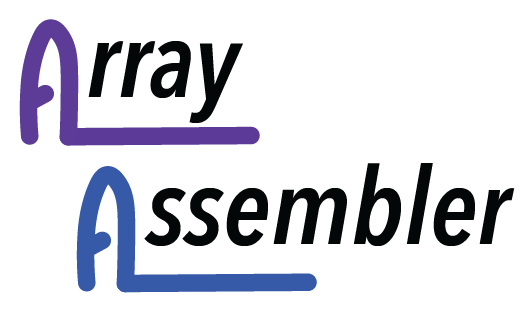

**Background**

The array assembler is a tool designed for taking you from spacer sequences for targeting given genes for manipulation with CRISPR tools and making a list of oligos to generate the corresponding targeting crRNA array.

Below the user should run the code cell (by pressing the play button next to them) before providing the respective  essential details (CRISPR variant, whether there is a direct repeat already present in the plasmid and the overhangs compatible with the plasmid cloning site). They can then directly paste the spacer sequences they want their crRNA array to be composed of, copied from a spreadsheet (or inserted manually) before being able to click to output an xlsx file that can be directly uploaded for commercial DNA synthesis.

Note, upon running the code cell they may be prompted 'Warning this notebook is not authored by google', to which after selecting 'Run anyway' all cells should be able to run as expected.

**Example workflow:**

**Sourcing spacer sequences (alternatively can be manually selected)**

1) In CRISPick (https://portals.broadinstitute.org/gppx/crispick/public) select the organism, the mechanism (CRISPRa/i etc) and AsCas12a. Then input your target gene(s) and number of gRNAs desired per gene before clicking 'Validate' and then 'Submit'.

2) Download the generated 'Picking Results' and open within Excel or similar software.

**Design of crRNA arrays using Array Assembler in this Google colab notebook**

3) Run the code cell (by clicking the play button) and select the AsCas12a variant from the drop-down menu 'Select CRISPR variant:'.

4) Select either yes or no from the drop-down menu 'Direct repeat present in plasmid:' depending on the presence of a direct repeat upstream of the cloning site.

5) Provide the sequence overhangs (5' to 3') for insertion into the plasmid cloning site after cleavage, for both the left and right overhang.

6) From step 2, select the gRNAs that you want to incorporate into a single crRNA array and copy the corresponding spacer sequences from the 'sgRNA Sequence' column and paste this into the text box 'Spacer sequences:'.

7) Click the 'Generate oligos' button and underneath the generated oligo list, click 'Download oligos'.

8) The downloaded xlsx file can then be directly uploaded for bulk oligo ordering (confirmed for IDT and Thermo Scientific) or copied and pasted into your chosen oligo provider's portal.

In [ ]:
# @title Run cell (by pressing the play button) and input key CRISPR/plasmid details below
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from google.colab import files

# Dictionary for direct repeat sequences
direct_repeat_dict = {
    "AsCas12a": "TAATTTCTACTCTTGTAGAT",
    "EeCas12a": "TAATTTCTACTTTGTAGAT",
    "FnCas12a": "TAATTTCTACTGTTGTAGAT",
    "LbCas12a": "TAATTTCTACTAAGTGTAGAT",
    "Mb3Cas12a": "TAATTTCTACTGTTTGTAGAT",
    "RbCas12a": "TAATTTCTACTATTGTAGAT",
    "RfxCas13d": "CAAGTAAACCCCTACCAACTGGTCGGGGTTTGAAAC",
    "Cas13X": "GCTGGAGCAGCCCCCGATTTGTGGGGTGATTACAGC"
}

# Generating the drop-down menu
crispr_var = widgets.Dropdown(
    options=['', 'AsCas12a', "EeCas12a", 'FnCas12a', 'LbCas12a', 'Mb3Cas12a', 'RbCas12a', 'RfxCas13d', 'Cas13X'],
    description='Select CRISPR variant:',
    style={'description_width': '138px'}
)

display(crispr_var)

# UI Component for Direct Repeat presence
DR_presence = widgets.Dropdown(
    options=['', 'Yes', 'No'],
    description='Direct repeat present in plasmid:',
    style={'description_width': '190px'}
)

display(DR_presence)

# @title Code cell 3 - Provide left and right overhang sequences for insertion into cloning site (here the reverse complement to the plasmid overhang nearest the pol3 promoter is the left overhang and the reverse complement to the plasmid overhang furthest from the pol3 promoter is the right overhang)


# UI Components for Left and Right Overhang sequences
leftOverhang = widgets.Text(
    value='',
    placeholder='e.g. AGAT',
    description='Left overhang Sequence (5\' to 3\'):',
    style={'description_width': '200px'},
    layout=widgets.Layout(width='500px')

)

rightOverhang = widgets.Text(
    value='',
    placeholder='e.g. AAAA',
    description='Right overhang Sequence (5\' to 3\'):',
    style={'description_width': '208px'},
    layout=widgets.Layout(width='500px')
)

display(leftOverhang, rightOverhang)

# @title Code cell 4 - Insert spacer sequences in order desired (can be pasted from spreadsheet column)

# UI Component for pasting spacer sequences
spacer_input_area = widgets.Textarea(
    value='',
    placeholder='Paste newline separated spacers, as below: \nACATCACCATCCAGTTCAAC \nTCCATGCCGTGCGTGATACC \nTTCCGGCATTGCAGATTTGA \nACCATAGGTCAGGGTAGTCA \nATTTCAGGGTCAGTTTACCG',
    description='Spacer Sequences:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px', height='100px')
)

display(spacer_input_area)


# Install required library for Excel file export
!pip install openpyxl

# UI Components
runButton = widgets.Button(description='Generate oligos')
outputMessage, outputTable, downloadButtonUI = widgets.Output(), widgets.Output(), widgets.Output()

# Perform input validation for CRISPR variant, direct repeat presence, and spacer sequences
def validate_inputs():
    if not crispr_var.value:
        print("Please select CRISPR variant.")
        return False
    if not DR_presence.value:
        print("Please select Direct repeat presence option.")
        return False
    if not leftOverhang.value.strip() or not rightOverhang.value.strip():
        print("Error: Please input both left and right overhang sequences.")
        return False
    if any(c not in "acgtACGT" for c in leftOverhang.value.strip() + rightOverhang.value.strip()):
        print("Error: Overhangs must only contain DNA nucleotides.")
        return False
    spacers = [line.strip() for line in spacer_input_area.value.strip().split('\n') if line.strip()]
    if not spacers:
        print("Please enter at least one spacer sequence.")
        return False
    if any(any(c not in "acgtACGT" for c in seq) for seq in spacers):
        print("Error: All spacer sequences must only contain DNA nucleotides.")
        return False
    return spacers

# Generate oligo sequences and calculate cuts based on input spacers and settings
def calculate_oligos(spacers, direct_rep, DR_present):
    lengths = [len(seq) for seq in spacers]
    spacers = [s + direct_rep for s in spacers]
    if not DR_present:
        spacers[0] = 'GG' + direct_rep + spacers[0]
    top_strand = ''.join(spacers).upper()
    complement = top_strand.translate(str.maketrans("ACGT", "TGCA"))

    top_overhanged = leftOverhang.value.strip() + top_strand
    bottom_overhanged = complement + rightOverhang.value.strip()[::-1]

    permitted_top = calculate_permitted(lengths, direct_rep, DR_present)
    #print("Permitted top:", permitted_top)  # Debug print for permitted_top

    cuts = calculate_cuts(permitted_top, len(top_overhanged), lengths)
    #print("Cuts:", cuts)  # Debug print for cuts

    bounded_cuts = [0] + cuts + [len(top_overhanged)]
    #print("Bounded cuts:", bounded_cuts)  # Debug print for bounded_cuts

    forward_oligos = [top_overhanged[bounded_cuts[i]:bounded_cuts[i + 1]] for i in range(len(bounded_cuts) - 1)]
    reverse_cuts = [0] + [x + 2 for x in cuts] + [len(bottom_overhanged)]
    #print("Reverse cuts:", reverse_cuts)  # Debug print for reverse_cuts

    reverse_oligos = [bottom_overhanged[reverse_cuts[i]:reverse_cuts[i + 1]][::-1] for i in range(len(reverse_cuts) - 1)]

    return forward_oligos, reverse_oligos

# Calculate permitted ranges for oligos based on input lengths and settings
def calculate_permitted(lengths, direct_rep, DR_present):
    c = 4 if DR_present else 4 + 2 + len(direct_rep)
    permitted_top = []
    for length in lengths:
        permitted_top.append((c, c + length - 6))
        c += len(direct_rep) + length
    return permitted_top

# Calculate cut positions for oligos within the allowed ranges
def calculate_cuts(permitted, seq_length, lengths):
    cuts, temp_cut, i = [], 0, 0
    while i < len(permitted):
        start, end = permitted[i]
        if start <= temp_cut + (58 if i == 0 else 60) <= end:
            temp_cut += 58 if i == 0 else 60
        elif end <= temp_cut + (58 if i == 0 else 60):
            temp_cut = end
        else:
            temp_cut = permitted[i - 1][1]
        cuts.append(temp_cut)
        i += 1
    if seq_length - cuts[-1] > 60:
        cuts.append(permitted[-1][1])
    return cuts

# Generate and display the output DataFrame and provide a download link
def generate_output(forward_oligos, reverse_oligos):
    forward_names = [f'oligo_{i+1}_F' for i in range(len(forward_oligos))]
    reverse_names = [f'oligo_{i+1}_R' for i in range(len(reverse_oligos))]

    forward_df = pd.DataFrame({'Name': forward_names, 'Sequence': forward_oligos})
    reverse_df = pd.DataFrame({'Name': reverse_names, 'Sequence': reverse_oligos})

    combined_df = pd.concat([forward_df, reverse_df])
    file_path = "/content/array_oligos.xlsx"
    combined_df.to_excel(file_path, index=False, engine='openpyxl')

    with outputTable:
        clear_output()
        display(combined_df)

    with downloadButtonUI:
        clear_output()
        download_button = widgets.Button(description="Download oligos")
        download_button.on_click(lambda x: files.download(file_path))
        display(download_button)

# Main function triggered on button click, handles the full workflow
def run_analysis(b):
    with outputMessage:
        clear_output()
        spacers = validate_inputs()
        if not spacers:
            return
        direct_rep = direct_repeat_dict[crispr_var.value]
        DR_present = DR_presence.value == "Yes"
        print("\nOligos generated in 5' to 3' orientation")
        forward_oligos, reverse_oligos = calculate_oligos(spacers, direct_rep, DR_present)
        generate_output(forward_oligos, reverse_oligos)

runButton.on_click(run_analysis)
display(runButton, outputMessage, outputTable, downloadButtonUI)

Dropdown(description='Select CRISPR variant:', options=('', 'AsCas12a', 'EeCas12a', 'FnCas12a', 'LbCas12a', 'M…

Dropdown(description='Direct repeat present in plasmid:', options=('', 'Yes', 'No'), style=DescriptionStyle(de…

Text(value='', description="Left overhang Sequence (5' to 3'):", layout=Layout(width='500px'), placeholder='e.…

Text(value='', description="Right overhang Sequence (5' to 3'):", layout=Layout(width='500px'), placeholder='e…

Textarea(value='', description='Spacer Sequences:', layout=Layout(height='100px', width='500px'), placeholder=…

Button(description='Generate oligos', style=ButtonStyle())

Output()

Output()

Output()